# How to load the BirdSet ConvNext model for inference

This notebook demonstrates how to load the BirdSet ConvNext model for inference. The model is trained on the BirdSet XCL dataset, covering 9736 bird species from Xeno-Canto. Please refer to the [BirdSet Paper](https://arxiv.org/abs/2403.10380) and the [BirdSet Repository](https://github.com/DBD-research-group/BirdSet) for further information.

## Get a sample bird sound file


In [8]:
import requests
import torchaudio
import io
import IPython.display as ipd


# download the audio file of a bird sound: Common Craw
url = "https://xeno-canto.org/704485/download"
response = requests.get(url)
audio, sample_rate = torchaudio.load(io.BytesIO(response.content))
print("Original shape and sample rate: ", audio.shape, sample_rate)
# crop to 5 seconds
audio = audio[:, : 5 * sample_rate]
# resample to 32kHz
resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=32000)
audio = resample(audio)
print("Resampled shape and sample rate: ", audio.shape, 32000)
ipd.Audio(audio.squeeze().numpy(), rate=32000)

Original shape and sample rate:  torch.Size([1, 436444]) 48000
Resampled shape and sample rate:  torch.Size([1, 160000]) 32000


## Load the model from the BirdSet package

In [9]:
from birdset import ConvNextBirdSet

model = ConvNextBirdSet()
# preprocess the audio
preprocessed = model.preprocess(audio)

logits = model(preprocessed)

# get the predicted label
model.config.id2label[logits.argmax().item()]

'comrav'

## Without any dependencies of the BirdSet library

In [24]:
from transformers import ConvNextForImageClassification
import torch
import torchaudio
from torchvision import transforms

CACHE_DIR = "../../data_birdset"  # Change this to your own cache directory

# Load the model
model = ConvNextForImageClassification.from_pretrained(
    "DBD-research-group/ConvNeXT-Base-BirdSet-XCL",
    cache_dir=CACHE_DIR,
    ignore_mismatched_sizes=True,
)


class PowerToDB(torch.nn.Module):
    """
    A power spectrogram to decibel conversion layer. See birdset.datamodule.components.augmentations
    """

    def __init__(self, ref=1.0, amin=1e-10, top_db=80.0):
        super(PowerToDB, self).__init__()
        # Initialize parameters
        self.ref = ref
        self.amin = amin
        self.top_db = top_db

    def forward(self, S):
        # Convert S to a PyTorch tensor if it is not already
        S = torch.as_tensor(S, dtype=torch.float32)

        if self.amin <= 0:
            raise ValueError("amin must be strictly positive")

        if torch.is_complex(S):
            magnitude = S.abs()
        else:
            magnitude = S

        # Check if ref is a callable function or a scalar
        if callable(self.ref):
            ref_value = self.ref(magnitude)
        else:
            ref_value = torch.abs(torch.tensor(self.ref, dtype=S.dtype))

        # Compute the log spectrogram
        log_spec = 10.0 * torch.log10(
            torch.maximum(magnitude, torch.tensor(self.amin, device=magnitude.device))
        )
        log_spec -= 10.0 * torch.log10(
            torch.maximum(ref_value, torch.tensor(self.amin, device=magnitude.device))
        )

        # Apply top_db threshold if necessary
        if self.top_db is not None:
            if self.top_db < 0:
                raise ValueError("top_db must be non-negative")
            log_spec = torch.maximum(log_spec, log_spec.max() - self.top_db)

        return log_spec


# Initialize the transformations

spectrogram_converter = torchaudio.transforms.Spectrogram(
    n_fft=1024, hop_length=320, power=2.0
)
mel_converter = torchaudio.transforms.MelScale(
    n_mels=128, n_stft=513, sample_rate=32_000
)
normalizer = transforms.Normalize((-4.268,), (4.569,))
powerToDB = PowerToDB(top_db=80)


def preprocess(audio, sample_rate_of_audio):
    """
    Preprocess the audio to the format that the model expects
    - Resample to 32kHz
    - Convert to melscale spectrogram n_fft: 1024, hop_length: 320, power: 2. melscale: n_mels: 128, n_stft: 513
    - Normalize the melscale spectrogram with mean: -4.268, std: 4.569 (from AudioSet)

    """
    # convert waveform to spectrogram
    spectrogram = spectrogram_converter(audio)
    spectrogram = spectrogram.to(torch.float32)
    melspec = mel_converter(spectrogram)
    dbscale = powerToDB(melspec)
    normalized_dbscale = normalizer(dbscale)
    # add dimension 3 from left
    normalized_dbscale = normalized_dbscale.unsqueeze(-3)
    return normalized_dbscale

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Preprocess the audio file

In [25]:
# preprocess the audio
preprocessed_audio = preprocess(audio, sample_rate)
preprocessed_audio.shape

torch.Size([1, 1, 128, 501])

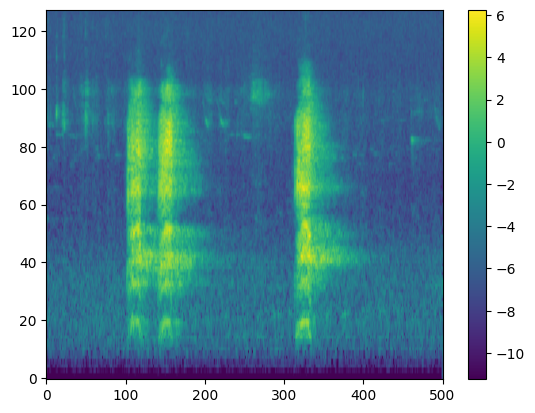

In [26]:
# visualize the preprocessed audio
import matplotlib.pyplot as plt

plt.imshow(preprocessed_audio.squeeze().numpy(), aspect="auto", origin="lower")
plt.colorbar()
plt.show()

### Run the model and get the top5 predictions

In [28]:
logits = model(preprocessed_audio).logits
print("Logits shape: ", logits.shape)
top5 = torch.topk(logits, 5)
print("Top 5 logits:", top5.values)
print("Top 5 predicted classes:")
print([model.config.id2label[i] for i in top5.indices.squeeze().tolist()])

Logits shape:  torch.Size([1, 9736])
Top 5 logits: tensor([[ 1.8531, -3.2249, -3.3164, -4.7356, -5.3482]],
       grad_fn=<TopkBackward0>)
Top 5 predicted classes:
['comrav', 'chirav', 'grswoo', 'y00678', 'blawoo1']
